# Octree quantization

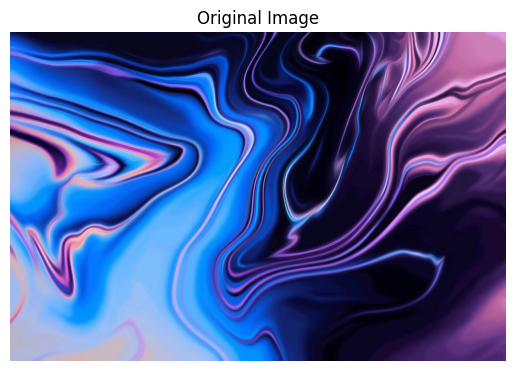

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('../../test-images-mnz/fluid_spill.jpg')

# Display the original image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()


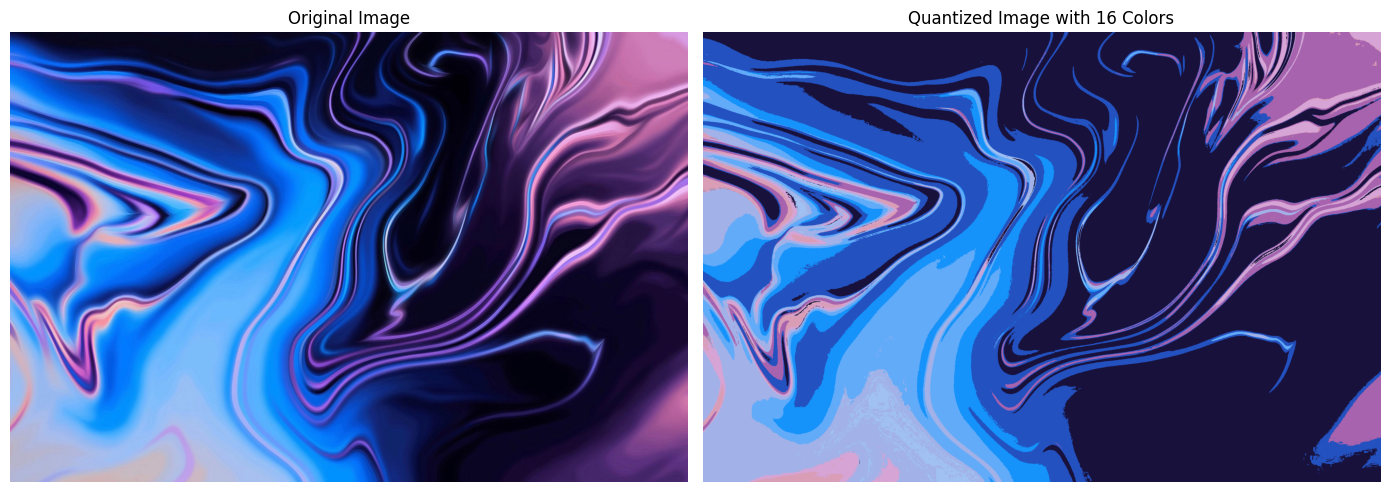

In [11]:
from color import Color
from octree_quantizer import OctreeQuantizer

# Initialize the quantizer
quantizer = OctreeQuantizer()

# Get image data
pixels = image.load()
width, height = image.size

# Add colors to the octree
for y in range(height):
    for x in range(width):
        r, g, b = pixels[x, y]
        quantizer.add_color(Color(r, g, b))

# Define the number of colors for the palette
num_colors = 16
palette = quantizer.make_palette(num_colors)

# Create a new image with quantized colors
quantized_image = Image.new('RGB', (width, height))
quantized_pixels = quantized_image.load()

for y in range(height):
    for x in range(width):
        r, g, b = pixels[x, y]
        index = quantizer.get_palette_index(Color(r, g, b))
        color = palette[index]
        quantized_pixels[x, y] = (color.red, color.green, color.blue)

# Display the quantized image
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

# Original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Quantized image
axes[1].imshow(quantized_image)
axes[1].set_title(f'Quantized Image with {num_colors} Colors')
axes[1].axis('off')

plt.tight_layout()
plt.show()
